In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pyplot
import matplotlib.image as Image
import keras
%matplotlib inline
import bcolz
from scipy.misc import imresize
from datetime import datetime, timedelta
try:
    utils
except:
    import utils
else:    
    reload(utils)
    print 'utils has been reloaded'

utils has been reloaded


In [7]:
# EMBEDDING CLASS TO BE USED
class Embedding:
    def __init__(self, topology='vgg16'):
        self.topology = topology
        self.network = keras.applications.vgg16.VGG16(include_top=True, weights='imagenet',
                                                      input_tensor=None,input_shape=None,
                                                      pooling=None, classes=1000)
        self.network.layers.pop() # Get rid of the classification layer
        self.network.outputs = [self.network.layers[-1].output]
        self.network.layers[-1].outbound_nodes = []
        for layer in self.network.layers: layer.trainable=False
    def get_vector(self, batch):
        return self.network.predict(batch)

In [69]:
a = np.arange(10)
b = bcolz.carray(a)
c = bcolz.carray(a, rootdir='data')
c.flush()

In [12]:
API_KEY = 'J9rmStnqj0ZhQFObVxh81O84hb7UQZjY'
N_FILES = 100
SEARCH_TERM = 'cat'

In [13]:
api_path = "http://api.giphy.com/v1/gifs/search?q={}&api_key={}&limit={}".format(SEARCH_TERM, API_KEY, N_FILES)
data = json.loads(urllib.urlopen(api_path).read())

In [32]:
utils.save_files(data,SEARCH_TERM)

In [ ]:
import os
for gif_file in os.listdir('gifs'):
    print 'gifs/'+gif_file

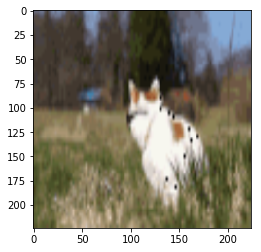

In [83]:
gif_file = 'cat_93.gif'
gif_file_path = 'gifs/'+gif_file
frames = utils.processImage(gif_file_path, reshape_to_vgg=True)
np.shape(frames)

pyplot.imshow(frames[0])

In [49]:
import h5py as h5py

In [58]:
embeddings = Embedding()

In [59]:
start_time = datetime.now()
embedding_matrix = embeddings.get_vector(data)
round(timedelta.total_seconds(datetime.now()-start_time)/60,2)

0.08

In [76]:
start_time = datetime.now()
embedding_matrix = embeddings.get_vector(frames)
round(timedelta.total_seconds(datetime.now()-start_time)/60,2)

0.87

In [78]:
embedding_matrix.shape
# in numpy slicing, last element is exclusive
# ex x[0:2,:] = x[[0,1],:]
max_index = embedding_matrix.shape[0]
seq_length = 10
data_dict = {}
data_arr = []
target_arr = []
for i in range(max_index-seq_length):
    start_ix = i
    end_ix = i+seq_length
    target_ix = end_ix
    data_arr.append(embedding_matrix[start_ix:end_ix,:])
    target_arr.append(embedding_matrix[[target_ix],:])

In [82]:
np.array(data_arr).shape,np.array(target_arr).shape

((104, 10, 4096), (104, 1, 4096))